In [1]:
from PIL import Image, ImageDraw
import os
import numpy as np
import torch
import torch.utils.data
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

In [2]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
 
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
 
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
 
        # split the color-encoded mask into a set
        # of binary masks
        masks = mask == obj_ids[:, None, None]
 
        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])
 
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
 
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
 
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd
 
        if self.transforms is not None:
            img, target = self.transforms(img, target)
 
        return img, target
 
    def __len__(self):
        return len(self.imgs)

In [3]:
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
 
    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
 
    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)
 
    return model

In [4]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T
 
 
def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [5]:
# use our dataset and defined transformations
dataset = PennFudanDataset('PennFudanPed', get_transform(train=True))
dataset_test = PennFudanDataset('PennFudanPed', get_transform(train=False))
 
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
 
# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=False, 
    collate_fn=utils.collate_fn)
 
data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, 
    collate_fn=utils.collate_fn)

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
 
# our dataset has two classes only - background and person
num_classes = 2
 
# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)
 
# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)
 
# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
C:\Users\young\anaconda3_1\envs\youngs\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=MaskRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
# let's train it for 10 epochs
num_epochs = 10
 
for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/60]  eta: 0:04:56  lr: 0.000090  loss: 2.8936 (2.8936)  loss_classifier: 0.7788 (0.7788)  loss_box_reg: 0.3483 (0.3483)  loss_mask: 1.7542 (1.7542)  loss_objectness: 0.0030 (0.0030)  loss_rpn_box_reg: 0.0093 (0.0093)  time: 4.9418  data: 0.0429  max mem: 2134
Epoch: [0]  [10/60]  eta: 0:00:53  lr: 0.000936  loss: 1.3660 (1.6949)  loss_classifier: 0.4909 (0.4799)  loss_box_reg: 0.2473 (0.3024)  loss_mask: 0.6302 (0.8927)  loss_objectness: 0.0107 (0.0154)  loss_rpn_box_reg: 0.0048 (0.0045)  time: 1.0688  data: 0.0310  max mem: 3594
Epoch: [0]  [20/60]  eta: 0:00:34  lr: 0.001783  loss: 0.9158 (1.2083)  loss_classifier: 0.1998 (0.3272)  loss_box_reg: 0.2304 (0.2718)  loss_mask: 0.3315 (0.5895)  loss_objectness: 0.0096 (0.0144)  loss_rpn_box_reg: 0.0045 (0.0054)  time: 0.6484  data: 0.0310  max mem: 3594
Epoch: [0]  [30/60]  eta: 0:00:23  lr: 0.002629  loss: 0.5519 (0.9866)  loss_classifier: 0.0894 (0.2507)  loss_box_reg: 0.2052 (0.2598)  loss_mask: 0.2098 (0.4578)  loss_ob

Epoch: [2]  [ 0/60]  eta: 0:00:38  lr: 0.005000  loss: 0.2735 (0.2735)  loss_classifier: 0.0471 (0.0471)  loss_box_reg: 0.0895 (0.0895)  loss_mask: 0.1266 (0.1266)  loss_objectness: 0.0035 (0.0035)  loss_rpn_box_reg: 0.0068 (0.0068)  time: 0.6465  data: 0.0229  max mem: 3594
Epoch: [2]  [10/60]  eta: 0:00:33  lr: 0.005000  loss: 0.2229 (0.2115)  loss_classifier: 0.0347 (0.0316)  loss_box_reg: 0.0570 (0.0595)  loss_mask: 0.1102 (0.1157)  loss_objectness: 0.0005 (0.0014)  loss_rpn_box_reg: 0.0025 (0.0034)  time: 0.6678  data: 0.0268  max mem: 3594
Epoch: [2]  [20/60]  eta: 0:00:26  lr: 0.005000  loss: 0.2036 (0.2155)  loss_classifier: 0.0246 (0.0289)  loss_box_reg: 0.0493 (0.0612)  loss_mask: 0.1119 (0.1203)  loss_objectness: 0.0004 (0.0012)  loss_rpn_box_reg: 0.0028 (0.0040)  time: 0.6506  data: 0.0287  max mem: 3594
Epoch: [2]  [30/60]  eta: 0:00:19  lr: 0.005000  loss: 0.1991 (0.2190)  loss_classifier: 0.0246 (0.0282)  loss_box_reg: 0.0454 (0.0624)  loss_mask: 0.1175 (0.1228)  loss_ob

Epoch: [4]  [ 0/60]  eta: 0:01:21  lr: 0.000500  loss: 0.2205 (0.2205)  loss_classifier: 0.0322 (0.0322)  loss_box_reg: 0.0619 (0.0619)  loss_mask: 0.1211 (0.1211)  loss_objectness: 0.0002 (0.0002)  loss_rpn_box_reg: 0.0050 (0.0050)  time: 1.3551  data: 0.0309  max mem: 3594
Epoch: [4]  [10/60]  eta: 0:00:42  lr: 0.000500  loss: 0.1800 (0.1709)  loss_classifier: 0.0244 (0.0265)  loss_box_reg: 0.0357 (0.0340)  loss_mask: 0.1048 (0.1070)  loss_objectness: 0.0003 (0.0004)  loss_rpn_box_reg: 0.0025 (0.0029)  time: 0.8584  data: 0.0282  max mem: 3594
Epoch: [4]  [20/60]  eta: 0:00:32  lr: 0.000500  loss: 0.1648 (0.1757)  loss_classifier: 0.0215 (0.0256)  loss_box_reg: 0.0308 (0.0357)  loss_mask: 0.1017 (0.1107)  loss_objectness: 0.0003 (0.0006)  loss_rpn_box_reg: 0.0025 (0.0031)  time: 0.7732  data: 0.0297  max mem: 3594
Epoch: [4]  [30/60]  eta: 0:00:23  lr: 0.000500  loss: 0.1589 (0.1748)  loss_classifier: 0.0187 (0.0244)  loss_box_reg: 0.0273 (0.0359)  loss_mask: 0.1074 (0.1106)  loss_ob

Epoch: [6]  [ 0/60]  eta: 0:00:38  lr: 0.000050  loss: 0.2198 (0.2198)  loss_classifier: 0.0365 (0.0365)  loss_box_reg: 0.0507 (0.0507)  loss_mask: 0.1188 (0.1188)  loss_objectness: 0.0095 (0.0095)  loss_rpn_box_reg: 0.0043 (0.0043)  time: 0.6363  data: 0.0279  max mem: 3594
Epoch: [6]  [10/60]  eta: 0:00:33  lr: 0.000050  loss: 0.1695 (0.1669)  loss_classifier: 0.0250 (0.0248)  loss_box_reg: 0.0306 (0.0327)  loss_mask: 0.1002 (0.1048)  loss_objectness: 0.0005 (0.0018)  loss_rpn_box_reg: 0.0024 (0.0027)  time: 0.6651  data: 0.0268  max mem: 3594
Epoch: [6]  [20/60]  eta: 0:00:26  lr: 0.000050  loss: 0.1573 (0.1659)  loss_classifier: 0.0182 (0.0234)  loss_box_reg: 0.0273 (0.0326)  loss_mask: 0.0999 (0.1058)  loss_objectness: 0.0003 (0.0012)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.6507  data: 0.0273  max mem: 3594
Epoch: [6]  [30/60]  eta: 0:00:19  lr: 0.000050  loss: 0.1521 (0.1676)  loss_classifier: 0.0170 (0.0226)  loss_box_reg: 0.0273 (0.0338)  loss_mask: 0.1032 (0.1071)  loss_ob

Epoch: [8]  [ 0/60]  eta: 0:00:47  lr: 0.000050  loss: 0.2119 (0.2119)  loss_classifier: 0.0310 (0.0310)  loss_box_reg: 0.0541 (0.0541)  loss_mask: 0.1187 (0.1187)  loss_objectness: 0.0036 (0.0036)  loss_rpn_box_reg: 0.0045 (0.0045)  time: 0.7989  data: 0.0299  max mem: 3594
Epoch: [8]  [10/60]  eta: 0:00:38  lr: 0.000050  loss: 0.1680 (0.1667)  loss_classifier: 0.0234 (0.0229)  loss_box_reg: 0.0317 (0.0336)  loss_mask: 0.1022 (0.1064)  loss_objectness: 0.0004 (0.0011)  loss_rpn_box_reg: 0.0023 (0.0027)  time: 0.7649  data: 0.0274  max mem: 3594
Epoch: [8]  [20/60]  eta: 0:00:29  lr: 0.000050  loss: 0.1562 (0.1678)  loss_classifier: 0.0178 (0.0236)  loss_box_reg: 0.0280 (0.0328)  loss_mask: 0.0995 (0.1079)  loss_objectness: 0.0003 (0.0008)  loss_rpn_box_reg: 0.0023 (0.0028)  time: 0.7338  data: 0.0281  max mem: 3594
Epoch: [8]  [30/60]  eta: 0:00:21  lr: 0.000050  loss: 0.1532 (0.1681)  loss_classifier: 0.0189 (0.0235)  loss_box_reg: 0.0250 (0.0330)  loss_mask: 0.0995 (0.1080)  loss_ob

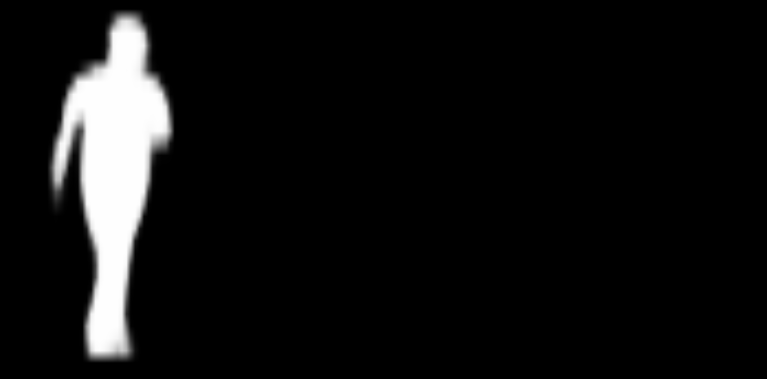

In [12]:
# pick one image from the test set
img, _ = dataset_test[12]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])
 
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())


number of detected people: 6


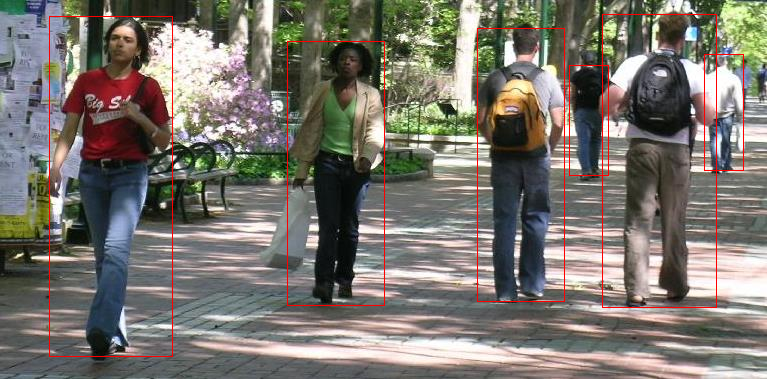

In [15]:
print('number of detected people: {}'.format(len(prediction[0]['boxes'])))
bbox = []
for i in range(len(prediction[0]['boxes'])):
    bbox.append(prediction[0]['boxes'].detach().cpu().numpy()[i])

pred_img = Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())
draw = ImageDraw.Draw(pred_img)
for i in range(len(prediction[0]['boxes'])):
    draw.rectangle(((bbox[i][0], bbox[i][1]), (bbox[i][2], bbox[i][3])), outline="red")

display(pred_img)